In [39]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import copy

# Helper Functions

In [2]:
def getNumFromOneHot(inp):
    for i in range(10):
        if inp[i] == 1:
            return i

In [3]:
def draw_stroke_sequence(sequence, save_path=None, show=True):
    """
    sequence: numpy array or list of shape (T, 4) where each row is [dx, dy, eos, eod]
    save_path: optional path to save the plot as an image
    show: whether to display the plot
    """
    x, y = 0, 0
    xs, ys = [], []

    for dx, dy, eos, eod in sequence:
        x += dx*28
        y += dy*28
        xs.append(x)
        ys.append(y)

        if eos > 0.5:  # end of stroke
            xs.append(None)
            ys.append(None)

        if eod > 0.5:
            break

    plt.figure(figsize=(2, 2))
    plt.plot(xs, ys, linewidth=2)
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.axis('equal')
    
    plt.show()

# 1. Loading the Data

In [4]:
indexes = np.loadtxt('good_indexes.txt').astype(int)

In [5]:
datas = [[] for _ in range(10)]

for i in indexes:
    try:
        data = np.loadtxt(f'../sequences/testimg-{i}-targetdata.txt', delimiter=' ')
    except FileNotFoundError:
        print(f"❌ File not found at path: {i}")
        continue
    
    inputOneshot = data[0, 0:10]
    outputStrokes = data[:, 10:]
    outputStrokes[:, 0] = outputStrokes[:, 0]/28
    outputStrokes[:, 1] = outputStrokes[:, 1]/28
    
    datas[getNumFromOneHot(inputOneshot)].append(outputStrokes)

In [6]:
amount = min([len(x) for x in datas])
amount

11

In [8]:
input_data = []
output_data = []

for i in range(10):
    temp_onehot = np.zeros(10)
    temp_onehot[i] = 1
    
    smallest_10 = sorted(datas[i], key=len)[:amount]
    for k in smallest_10:
        input_data.append(temp_onehot)
        output_data.append(k)

In [9]:
# Finding the max length of a sequence
max_length = 0
j = 0
for i in range(len(output_data)):
    if len(output_data[i]) > max_length:
        max_length = len(output_data[i])
    j += 1

In [10]:
# Padding the sequences so that they are all the same size (good for batching)
padded_output_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_output_data[i, :len(output_data[i]), :] = output_data[i]
    padded_output_data[i, len(output_data[i]):, :] = [0, 0, 0, 1]

In [11]:
padded_input_data = np.zeros( (len(output_data), max_length, 4) )

for i in range(len(output_data)):
    padded_input_data[i, 0, :] = [0, 0, 0, 0]
    padded_input_data[i, 1:, :] = padded_output_data[i, :max_length-1, :]

# 2. Setting up the Dataset for Training

In [12]:
class StrokeDataset(Dataset):
    def __init__(self, onehot, inputs, outputstroke):
        self.digit = onehot                     # shape: [N]
        self.inputstroke = inputs               # list of [seq_len, 4] arrays
        self.outputstroke = outputstroke        # list of [seq_len, 4] arrays

    def __len__(self):
        return len(self.digit)

    def __getitem__(self, idx):
        digit = self.digit[idx]
        inputs = self.inputstroke[idx]
        outputs = self.outputstroke[idx]
        return torch.tensor(digit, dtype=torch.float32), torch.tensor(inputs, dtype=torch.float32), torch.tensor(outputs, dtype=torch.float32)

In [13]:
strokeDataset = StrokeDataset(input_data, padded_input_data, padded_output_data)

In [14]:
loader = DataLoader(strokeDataset, batch_size=32, shuffle=True)

# 3. Creating Model

In [15]:
class DigitToStrokeLSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, batch_size=32):
        super(DigitToStrokeLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.embedding = nn.Linear(10, hidden_size)  # From one-hot to hidden dim
        
        # LSTM
        # Output layer: predicts [dx, dy, eos, eod]
        # Inital hidden state is the one-hot of number
        # Initial input is [0, 0, 0, 0, 0]
        # Input at t > 0 is output from t-1
        
        self.lstm = nn.LSTM(
            input_size=4,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3
        )

        # Output layer: predicts [dx, dy, eos, eod]
        self.output_head = nn.Linear(hidden_size, 4)
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()  # For eos/eod
        self.tanh = nn.Tanh()


    def forward(self, x, hidden=None, onehot_digit=None):
        
        if onehot_digit != None and hidden == None:
            # Embed the digit
            h0 = self.embedding(onehot_digit)
            h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
            c0 = torch.zeros_like(h0)
            hidden = (h0, c0)

        elif hidden == None and onehot_digit == None:
            hidden = (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                      torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
            
        out, hidden = self.lstm(x, hidden)
        out = self.dropout(out)
        
        out = self.output_head(out)
        
        out[:, :, 0:2] = self.tanh(out[:, :, 0:2])
        # out[:, :, 2:] = self.sigmoid(out[:, :, 2:])
        
        return out, hidden
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Training Model

In [16]:
model = DigitToStrokeLSTM(hidden_size = 512, num_layers=2).to(device)
dx_dy_loss_fn = nn.MSELoss()
eos_eod_loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
n_epochs = 5000

best_model_wts = None
best_loss = 99999

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for (dig, input_seq, output_seq) in loader:
        # stroke_seq: [batch, seq_len, 4]
        input_seq = input_seq.to(device)
        target_seq = output_seq.to(device)
        dig = dig.to(device)

        pred_seq, hidden = model(input_seq, onehot_digit = dig)  # [batch, seq_len-1, 4]

        # Separate predictions
        pred_dxdy = pred_seq[..., :2]         # [batch, seq_len-1, 2]
        pred_eos_eod = pred_seq[..., 2:]      # [batch, seq_len-1, 2]

        # Separate targets
        target_dxdy = target_seq[..., :2]
        target_eos_eod = target_seq[..., 2:]

        # Compute losses
        loss_dxdy = dx_dy_loss_fn(pred_dxdy, target_dxdy)
        loss_eos_eod = eos_eod_loss_fn(pred_eos_eod, target_eos_eod)

        loss = loss_dxdy + loss_eos_eod

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

Epoch 1 | Loss: 0.0020
Epoch 2 | Loss: 0.0018
Epoch 3 | Loss: 0.0023
Epoch 4 | Loss: 0.0021
Epoch 5 | Loss: 0.0014
Epoch 6 | Loss: 0.0015
Epoch 7 | Loss: 0.0018
Epoch 8 | Loss: 0.0016
Epoch 9 | Loss: 0.0022
Epoch 10 | Loss: 0.0021
Epoch 11 | Loss: 0.0017
Epoch 12 | Loss: 0.0021
Epoch 13 | Loss: 0.0022
Epoch 14 | Loss: 0.0018
Epoch 15 | Loss: 0.0016
Epoch 16 | Loss: 0.0023
Epoch 17 | Loss: 0.0016
Epoch 18 | Loss: 0.0016
Epoch 19 | Loss: 0.0021
Epoch 20 | Loss: 0.0019
Epoch 21 | Loss: 0.0016
Epoch 22 | Loss: 0.0022
Epoch 23 | Loss: 0.0019
Epoch 24 | Loss: 0.0017
Epoch 25 | Loss: 0.0020
Epoch 26 | Loss: 0.0015
Epoch 27 | Loss: 0.0015
Epoch 28 | Loss: 0.0017
Epoch 29 | Loss: 0.0016
Epoch 30 | Loss: 0.0025
Epoch 31 | Loss: 0.0017
Epoch 32 | Loss: 0.0020
Epoch 33 | Loss: 0.0020
Epoch 34 | Loss: 0.0019
Epoch 35 | Loss: 0.0019
Epoch 36 | Loss: 0.0019
Epoch 37 | Loss: 0.0017
Epoch 38 | Loss: 0.0014
Epoch 39 | Loss: 0.0019
Epoch 40 | Loss: 0.0021
Epoch 41 | Loss: 0.0062
Epoch 42 | Loss: 0.0059
E

KeyboardInterrupt: 

In [55]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [56]:
def generate_text(number):
    model.eval()
    
    temp_onehot = np.zeros(10)
    temp_onehot[number] = 1
    temp_onehot = torch.tensor(temp_onehot, dtype=torch.float32).to(device)
    
    initial_input = torch.tensor([0, 0, 0, 0], dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(1)
    
    outputs = []
    
    output, hidden = model(initial_input, onehot_digit=temp_onehot)
    output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()

    outputs.append(output[:, -1, :].detach().cpu().numpy()[0])

    for i in range(max_length-1):
        output, hidden = model(output, hidden=hidden)
        output[..., 2:] = (torch.sigmoid(output[..., -1, 2:]) > 0.5).float()
        outputs.append(output[:, -1, :].detach().cpu().numpy()[0])
        
        # print(outputs[-1])
        if output[:, -1, 3] == 1:
            # print("HI")
            break
    
    draw_stroke_sequence(outputs)


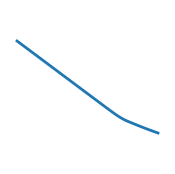

In [72]:
generate_text(9)

In [69]:
# Save model if good
torch.save(model.state_dict(), 'model_weights/sketch_model_weights2.pth')

In [75]:
model = model = DigitToStrokeLSTM(hidden_size = 512, num_layers=2).to(device)
model.load_state_dict(torch.load('model_weights/sketch_model_weights2.pth', weights_only=True))
model.eval()  # set to evaluation mode if you're doing inference

DigitToStrokeLSTM(
  (embedding): Linear(in_features=10, out_features=512, bias=True)
  (lstm): LSTM(4, 512, num_layers=2, batch_first=True, dropout=0.3)
  (output_head): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
)

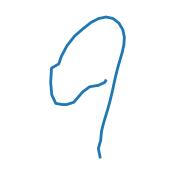

In [85]:
generate_text(9)